In [1]:
# Import necessary modules
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import sys
import chess

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from tensorflow.keras import layers, regularizers
from keras.layers import Dense, Conv2D, Flatten

from pandarallel import pandarallel
import multiprocessing

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
%matplotlib inline

2023-05-25 01:25:09.243090: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 01:25:12.630099: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-25 01:25:12.630256: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [2]:
num_cpus = multiprocessing.cpu_count()
pandarallel.initialize(progress_bar = True, nb_workers = num_cpus - 4)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


I'm creating a custom dataset using chess games played by me online on two major chess platforms namely Chess.com and Lichess.org. In addition to the games played by me, there also consists games played by my friends and family members, and various other people whose positions were publicly available on the aforementioned websites. 

The dataset comprises approximately 3M observation after sampling randomly, and their corresponding evaluations by Stockfish. Stockfish is a strongest chess engine that Grandmasters use to prepare for tournaments and championships. 

# Loading the dataset

In [3]:
df = pd.read_csv("Data/chess_PM.csv")
df.shape

(12958035, 2)

In [4]:
df = df.sample(1000000)
df = df.reset_index()
df = df.drop("index", axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   FEN         1000000 non-null  object
 1   Evaluation  1000000 non-null  object
dtypes: object(2)
memory usage: 15.3+ MB


In [5]:
df["FEN"] = df["FEN"].astype(str)
df["Evaluation"] = df["Evaluation"].astype(str)

In [6]:
df = df.parallel_applymap(lambda x: x.replace("\ufeff", "") if isinstance(x, str) else x)

In [7]:
df

,FEN,Evaluation
0,q3r1k1/P4ppp/3R4/1bB1p3/1P6/4PP1P/6P1/Q5K1 b - - 1 36,+658
1,5r2/1pr1bkp1/2q1ppp1/2P5/R1BPpP2/4Q2P/7K/2R5 w - - 6 31,+15
2,r1bqk2r/p1p2ppp/2np1n2/2B5/4P3/2N5/PPPQ1PPP/2KR3R w kq - 0 12,-251
3,1q3r1k/5ppb/prnp1b1p/2pR3P/2B1P1Q1/PP3N2/R4PP1/2B3K1 b - - 2 22,-78
4,2r3k1/p4ppp/4p3/2P5/2Q1p2P/1r6/3q1PP1/2R2K1R w - - 1 25,-480
...,...,...
999995,4r2k/1pp3pp/5p2/p2bq3/P2N2P1/2P4P/1P1Q1P2/3R2K1 b - - 7 29,-48
999996,2r1k3/3R1pp1/2p4p/8/8/7P/PPP2PP1/6K1 w - - 3 28,+350
999997,rn1q2k1/pb1nprbp/3P2p1/2p5/P1B5/2N4P/1P3PP1/R1BQR1K1 b - - 0 15,+310
999998,8/5p2/4pn1k/5rpp/8/6K1/3Q4/8 w - - 2 60,-782


As we can see above, the dataframe has a column called `FEN`. FEN is a standard notation for describing a particular board position of a Chess game in one text line and using only the ASCII character set. The purpose of FEN is to provide all the necessary information to restart a game from a particular position. Each chess position is represented as a FEN, or a string of characters that represent all the information about each piece, their location on the board, whose turn it is, castling ability and options, and the number of moves since a capture. 

More information on how to understand and interpret a FEN string can be found [here](https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation).

# Exploratory Data Analysis

In [8]:
df2 = df.copy()

In [9]:
df2.describe()

,FEN,Evaluation
count,1000000,1000000
unique,999974,8265
top,r2qkb1r/1p1b1ppp/p1nppn2/8/3NP3/2N1B1P1/PPP2PBP/R2QK2R w KQkq - 2 9,0
freq,2,97354


In [10]:
df2["FEN"].value_counts()

r2qkb1r/1p1b1ppp/p1nppn2/8/3NP3/2N1B1P1/PPP2PBP/R2QK2R w KQkq - 2 9       2
4k3/pp2qpp1/1b2pn1p/3rN2P/5BP1/5Q2/PP6/1KR5 w - - 2 30                    2
r1b2rk1/pp2qpbp/6p1/8/3n4/4B3/PPPQBPPP/R3K2R w KQ - 0 12                  2
2r3k1/1q3pp1/1bpBp2p/1p2P2P/1P2Q3/5PPK/4P3/2R5 w - - 3 38                 2
r1b1k2r/1pq1bppp/p1nppn2/2p5/P3PP2/2NP1NP1/1PP3BP/R1BQK2R w KQkq - 1 9    2
                                                                         ..
r1bq1rk1/p4pbp/1n1pp1p1/2pP4/2P1Pn2/4NN2/P1B2PPP/1RBQR1K1 b - - 9 15      1
8/4K1p1/3Np1kp/r3P3/8/5RPb/8/8 w - - 42 73                                1
r1bq4/ppp1nBpk/2np3p/3N2BQ/4P3/8/P4PPP/R5K1 b - - 0 16                    1
2r5/p4kb1/1p2p3/4PpB1/3P1P2/2p1K3/PP6/7R w - - 0 36                       1
8/8/1p1p4/1PpP1kp1/3b4/1P1N1P1P/4K3/8 b - - 17 68                         1
Name: FEN, Length: 999974, dtype: int64

There are some duplicate values in the `FEN` column. This tells me that there are some positions that have occured twice. I will drop these duplicate value.

In [11]:
df2 = df2.drop_duplicates(keep = "first")
df2.shape

(999997, 2)

In [12]:
has_neg = df2["Evaluation"].str.contains("-")
has_hash = df2["Evaluation"].str.contains("#")
has_pos = df2["Evaluation"].str.contains("\+")

In [13]:
frequency = [has_pos.sum(), (df2.shape[0] - has_neg.sum() - has_hash.sum() - has_pos.sum()), has_neg.sum(), has_hash.sum()]
labels = ["+", "0", "-", "#"]

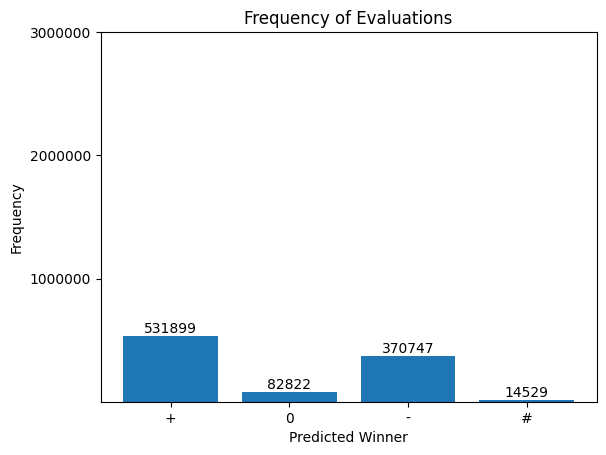

In [14]:
plt.bar(labels, frequency)
plt.xlabel("Predicted Winner")
plt.ylabel("Frequency")
plt.title("Frequency of Evaluations")
plt.ylim(0, 3000000)
plt.yticks([1e6, 2e6, 3e6], ["1000000", "2000000", "3000000"])
for i in range(len(labels)):
    plt.text(i, frequency[i], str(frequency[i]), ha = "center", va = "bottom")
plt.show()

# Feature Engineering and Transformations
Since the positions are represented by FEN strings, I am creating a function that parses the FEN string and returns a numpy array that one-hot encodes the different piece types. The FEN strings provides the reader with the ability to determine who's move/turn it is. This is given by the lowercase letters `w` and `b`. I want my model to learn from the perspective of the player whose turn it is. In order to acheive this, I normalized the chess position by reversing the colors of the pieces and the order of the rows in the FEN string to ensure it is white's turn (as white starts the game). In order to obtain predictions for the opponent, one can flip the chess board and pass the position to the model. Once the output is received, remember to reverse the output.

In [15]:
pieces = ["P", "N", "B", "R", "Q", "K"]
piece_map = {i: pieces.index(i) for i in pieces}

In [16]:
def parse_row(row):
    res = []
    for i in row:
        sq = [0] * len(piece_map) * 2
        if i in piece_map:
            sq[piece_map[i]] = 1
        elif i.upper() in piece_map:
            sq[piece_map[i.upper()] + len(piece_map)] = 1
        if i in "1234567890":
            n = int(i) 
        else:
            n = 1
        for i in range(n):
            res.append(sq)
    return res

def parse_fen(fen):
    pos, move, *_ = fen.split(" ")
    if move == "b":
        pos = "".join(reversed(pos.swapcase()))
    pos = [parse_row(i) for i in pos.split("/")]
    pos = np.array(pos)
    return (pos, move == "b")

In [17]:
parse_fen("rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1")

(array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       

The `Evaluation` column is also stored as a string rather than an integer. 
Below is a function that parses the evaluations and one-hot encodes it into either "white winning", "equal", or "black winning".
A higher positive evaluation means white is winning and a higher negative evaluation means black is winning. 
The corresponding thresholds of 100 and -100 have been set based on my experiences of playing and following the game for more than 20 years. 

In [18]:
def parse_eval(ev):
    if ev[0] == "#":
        ev = ev[1:] + "000"
    ev = eval(str(ev))
    if ev > 100:
        return 0
    if ev < -100:
        return 2
    return 1

def preprocess(row):
    row[0], flip = parse_fen(row[0])
    row[1] = parse_eval(row[1])
    if flip:
        row[1] = 2 - row[1]
    row[1] = np.array([1 if i == row[1] else 0 for i in range(3)])
    return row

In [19]:
data = df2.copy().parallel_apply(preprocess, axis = 1)

In [20]:
data.columns = ["Position", "Evaluation"]

In [21]:
data

,Position,Evaluation
0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]]","[0, 0, 1]"
1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 

In [22]:
X, y = np.stack(data.Position, axis = 0), np.stack(data.Evaluation, axis = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Calculating the Number of Wins for White, Number of Draws, and Number of Wins for Black, respectively

In [23]:
wins = np.array([0, 0, 0])
def get_win_count(x):
    global wins
    wins += x
data["Evaluation"].apply(get_win_count)
wins

array([308676, 464658, 226663])

# The CNN Model

In [24]:
model = Sequential([
    Conv2D(filters = 200, kernel_size = 4, activation = "relu", padding = "same", input_shape = [8, 8, 12]),
    Conv2D(filters = 100, kernel_size = 2, activation = "relu", padding = "same"), 
    Flatten(),
    Dense(units = 3, activation = "relu", kernel_regularizer=regularizers.l1(0.01)),
])

2023-05-25 01:26:50.482925: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-25 01:26:50.484750: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-25 01:26:50.484802: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (final-project-ml): /proc/driver/nvidia/version does not exist
2023-05-25 01:26:50.488403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the

In [25]:
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["categorical_accuracy"])

In [26]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 200)         38600     
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 100)         80100     
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 3)                 19203     
                                                                 
Total params: 137,903
Trainable params: 137,903
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size = 128, 
                    verbose = 1, workers = num_cpus - 4, use_multiprocessing = True)

2023-05-25 01:26:50.765514: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 4915181568 exceeds 10% of free system memory.


Epoch 1/100
6250/6250 [==============================] - 161s 26ms/step - loss: 1.3343 - categorical_accuracy: 0.4617 - val_loss: 1.1928 - val_categorical_accuracy: 0.4779
Epoch 2/100
6250/6250 [==============================] - 155s 25ms/step - loss: 1.0528 - categorical_accuracy: 0.5149 - val_loss: 0.9848 - val_categorical_accuracy: 0.5545
Epoch 3/100
6250/6250 [==============================] - 157s 25ms/step - loss: 0.9955 - categorical_accuracy: 0.5541 - val_loss: 0.9524 - val_categorical_accuracy: 0.5756
Epoch 4/100
6250/6250 [==============================] - 147s 24ms/step - loss: 0.9597 - categorical_accuracy: 0.5735 - val_loss: 0.9456 - val_categorical_accuracy: 0.5832
Epoch 5/100
6250/6250 [==============================] - 145s 23ms/step - loss: 0.9738 - categorical_accuracy: 0.5731 - val_loss: 1.0314 - val_categorical_accuracy: 0.5557
Epoch 6/100
6250/6250 [==============================] - 141s 23ms/step - loss: 0.9471 - categorical_accuracy: 0.5838 - val_loss: 0.9376 - v

In [28]:
model.save("chess_predictor.h5")
print("Saved model")

Saved model


In [35]:
# model = load_model("chess_predictor.h5")

In [36]:
model.evaluate(X_test, y_test, batch_size = 128, use_multiprocessing = True, workers = num_cpus - 4)

1563/1563 [==============================] - 11s 7ms/step - loss: 0.9414 - categorical_accuracy: 0.5939


[0.9413820505142212, 0.593904972076416]

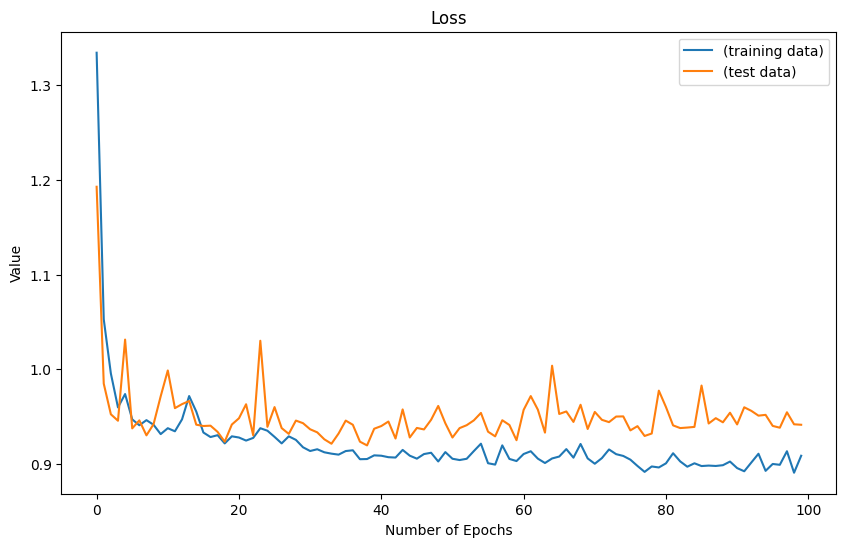

In [37]:
fig = plt.figure(figsize = (10, 6))
plt.plot(history.history["loss"], label = "(training data)")
plt.plot(history.history["val_loss"], label = "(test data)")
plt.ylabel("Value")
plt.xlabel("Number of Epochs")
plt.legend(loc = "upper right")
plt.title("Loss")
plt.show()

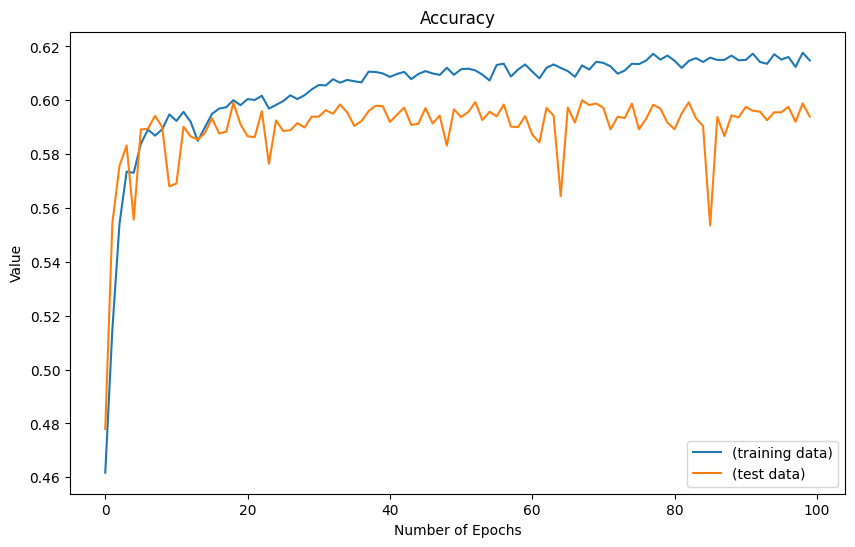

In [38]:
fig = plt.figure(figsize = (10, 6))
plt.plot(history.history["categorical_accuracy"], label = "(training data)")
plt.plot(history.history["val_categorical_accuracy"], label = "(test data)")
plt.ylabel("Value")
plt.xlabel("Number of Epochs")
plt.legend(loc = "lower right")
plt.title("Accuracy")
plt.show()

In [39]:
def predict(fen):
    pos, flip = parse_fen(fen)
    prediction = model.predict(pos[np.newaxis, ...])
    prediction = prediction.reshape(3)
    prediction = np.argmax(prediction)
    if flip:
        prediction = 2 - prediction
    return prediction

In [40]:
# 1
predict("rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1")

1/1 [==============================] - 0s 25ms/step


1

In [41]:
# 0
predict("5r2/1pr1bkp1/2q1ppp1/2P5/R1BPpP2/4Q2P/7K/2R5 w - - 6 31")

1/1 [==============================] - 0s 28ms/step


0

In [44]:
# 2
predict("4r2k/1pp3pp/5p2/p2bq3/P2N2P1/2P4P/1P1Q1P2/3R2K1 b - - 7 29")

1/1 [==============================] - 0s 28ms/step


1

In [45]:
# 0
predict("8/8/1p1p4/1PpP1kp1/3b4/1P1N1P1P/4K3/8 b - - 17 68")

1/1 [==============================] - 0s 42ms/step


2

In [40]:
def evaluate(board, depth, a = -1000, b = 1000):
    if board.is_checkmate():
        return (-1000, None)
    if depth == 0:
        prediction = model.predict(
            parse_fen(board.fen())[0][np.newaxis, ...]
        )[0]
        return (prediction[0] - prediction[2], None)
    else:
        best_move = None
        for mv in board.legal_moves:
            newboard = board.copy(stack=False)
            newboard.push(mv)
            newboard.apply_mirror()
            tup = evaluate(newboard, depth - 1, -b, -a)
            ev = -tup[0]
            if ev > a:
                a = ev
                best_move = mv
            if a >= b:
                return (b, best_move)
    return (a, best_move)

In [42]:
def player_1(depth = 2, print_board = True):
    import random
    board = chess.Board()
    print(board)
    print("-"*100)
    try:
        for i in range(30):
            ev, mv = evaluate(board, depth)
            board.push(mv)
            print(mv)
            if print_board: 
                print(board)

            mv = random.choice(list(board.legal_moves))
            board.push(mv)
            print(mv)
            if print_board: 
                print(board)
                print("-"*100)
    except:
        pass

def flip_move(mv):
    def flip_square(sq):
        return 8 * (7 - (sq // 8)) + sq % 8
    mv.from_square = flip_square(mv.from_square)
    mv.to_square = flip_square(mv.to_square)

def player_2(depth = 2, print_board = True):
    import random
    board = chess.Board()
    print(board)
    try:
        for i in range(30):
            ev, mv = evaluate(board, depth)
            board.push(mv)
            print(mv)
            if print_board: 
                print(board)

            board.apply_mirror()
            ev, mv = evaluate(board, depth)
            board.push(mv)
            board.apply_mirror()
            flip_move(mv)
            print(mv)
            if print_board: 
                print(board)
                print("-"*100)
    except:
        pass

In [ ]:
# player_1()
# player_2()